In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from tqdm import tqdm

import seaborn as sns
sns.set(font_scale=2)
import matplotlib.pyplot as plt

import xgboost as xgb

In [2]:
csv_file = "dataset_1.csv"

train_benign = pd.read_csv("/home/sharedrive/ids_dataset/MyInSDNDataset/flows/train/dataset_1_.csv")
train_attack = pd.read_csv("/home/sharedrive/ids_dataset/MyInSDNDataset/flows/train/dataset_1.csv")

train_df = pd.concat([train_benign, train_attack])

# train_df = pd.read_csv("/home/sharedrive/ids_dataset/MyInSDNDataset/flows/train/"+csv_file)
test_df = pd.read_csv("/home/sharedrive/ids_dataset/MyInSDNDataset/flows/test/"+csv_file)
val_df = pd.read_csv("/home/sharedrive/ids_dataset/MyInSDNDataset/flows/val/"+csv_file)

In [3]:
len(test_df)

454641

In [4]:
len(train_df)

1382056

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382056 entries, 0 to 1259283
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   flow_id        1382056 non-null  object 
 1   protocol       1382056 non-null  int64  
 2   pckt_received  1382056 non-null  int64  
 3   byte_received  1382056 non-null  int64  
 4   avg_pckt_size  1382056 non-null  float64
 5   label          1382056 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 73.8+ MB


In [6]:
train_df.describe()

,protocol,pckt_received,byte_received,avg_pckt_size
count,1.382056e+06,1.382056e+06,1.382056e+06,1.382056e+06
mean,1.315147e+01,7.022286e+00,2.599895e+03,9.548758e+01
std,5.260337e+00,8.209086e+02,2.719655e+05,2.820855e+02
min,1.000000e+00,1.000000e+00,4.200000e+01,4.200000e+01
25%,6.000000e+00,1.000000e+00,8.400000e+01,4.200000e+01
50%,1.700000e+01,2.000000e+00,8.400000e+01,4.200000e+01
75%,1.700000e+01,2.000000e+00,1.120000e+02,7.571429e+01
max,1.700000e+01,5.550320e+05,2.384360e+08,3.762400e+04


In [7]:
train_df["protocol"].unique()

array([ 6, 17,  1])

<BarContainer object of 2 artists>

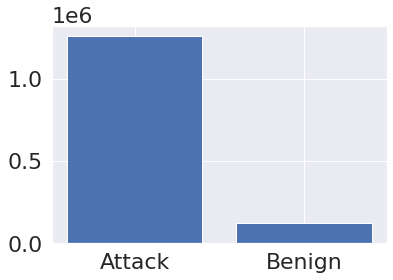

In [8]:
plt.bar(["Attack", "Benign"], [len(train_df[train_df["label"]=="attack"]), \
                               len(train_df[train_df["label"]=="benign"])])

In [9]:
fraction = len(train_df[train_df["label"]=="benign"])/len(train_df[train_df["label"]=="attack"])
attack_df = train_df[train_df["label"]=="attack"].sample(frac=fraction, random_state=1001)
benign_df = train_df[train_df["label"]=="benign"]
balanced_train_df = pd.concat([attack_df, benign_df])
balanced_train_df = balanced_train_df.sample(frac=1).reset_index(drop=True) # drop = True prevents .reset_index 
                                                                # from creating a column containing the
                                                                # old index entries.

<BarContainer object of 2 artists>

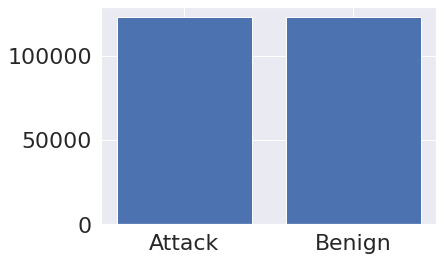

In [10]:
plt.bar(["Attack", "Benign"], [len(balanced_train_df[balanced_train_df["label"]=="attack"]),\
                               len(balanced_train_df[balanced_train_df["label"]=="benign"])])

In [11]:
len(balanced_train_df)

245544

In [12]:
# train df
one_hot_protocol = pd.get_dummies(balanced_train_df["protocol"])
balanced_train_df.drop("protocol", axis=1, inplace=True)
balanced_train_df["UDP_protocol"] = one_hot_protocol[17]
balanced_train_df["TCP_protocol"] = one_hot_protocol[6]
balanced_train_df["ICMP_protocol"] = one_hot_protocol[1]
# test_df
one_hot_protocol = pd.get_dummies(test_df["protocol"])
test_df.drop("protocol", axis=1, inplace=True)
test_df["UDP_protocol"] = one_hot_protocol[17]
test_df["TCP_protocol"] = one_hot_protocol[6]
test_df["ICMP_protocol"] = one_hot_protocol[1]
# val df
one_hot_protocol = pd.get_dummies(val_df["protocol"])
val_df.drop("protocol", axis=1, inplace=True)
val_df["UDP_protocol"] = one_hot_protocol[17]
val_df["TCP_protocol"] = one_hot_protocol[6]
val_df["ICMP_protocol"] = one_hot_protocol[1]

In [13]:
balanced_train_df.head()

,flow_id,pckt_received,byte_received,avg_pckt_size,label,UDP_protocol,TCP_protocol,ICMP_protocol
0,00:00:00:00:00:03_00:0c:29:92:12:d8_53298_443_6,1,54,54.000000,benign,0,1,0
1,00:00:00:00:00:01_00:00:00:00:00:04_38132_80_6,1,174,174.000000,attack,0,1,0
2,00:00:00:00:00:01_00:00:00:00:00:04_27866_80_17,2,84,42.000000,attack,1,0,0
3,00:0c:29:92:12:c4_00:0c:29:fa:dd:2a_46705_80_6,9,670,74.444444,attack,0,1,0
4,00:50:56:f2:90:f8_00:00:00:00:00:03_443_55162_6,12,11757,979.750000,benign,0,1,0


In [14]:
features = ["pckt_received", "byte_received", "avg_pckt_size", "UDP_protocol", "TCP_protocol", "ICMP_protocol"]
X_train = balanced_train_df[features]
X_test = test_df[features]
X_val = val_df[features]
y_train = balanced_train_df["label"]
y_test = test_df["label"]
y_val = val_df["label"]

In [15]:
# Scaling the data
train_scaler = StandardScaler()
train_scaled_X = train_scaler.fit_transform(X_train)
val_scaled_X = train_scaler.transform(X_val)
test_scaled_X = train_scaler.transform(X_test)

In [16]:
# Label preparation for RandomForest
le = LabelEncoder()
le.fit(y_train)
#y_test_encoded = le.transform(y_test)
#y_val_encoded = le.transform(y_val)
y_train_encoded = le.transform(y_train)

In [17]:
le.transform(["attack", "benign"])

array([0, 1])

In [21]:
RF_model = RandomForestClassifier()
# Train the model on training data
RF_model.fit(train_scaled_X, y_train_encoded)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(val_scaled_X)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

Accuracy =  0.9940235027866475
Precision =  0.9754811943746065
Recall =  0.9914759191569145
F1 =  0.9833087539621761
[[414077   2231]
 [   526  44473]]


<AxesSubplot:>

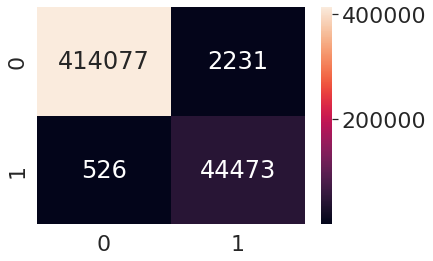

In [22]:
print("Accuracy = ", metrics.accuracy_score(y_val, prediction_RF))
print("Precision = ", metrics.precision_score(y_val, prediction_RF, average='macro'))
print("Recall = ", metrics.recall_score(y_val, prediction_RF, average='macro'))
print("F1 = ", metrics.f1_score(y_val, prediction_RF, average='macro'))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_val, prediction_RF)
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

In [23]:
import pickle
pickle.dump(RF_model, open("./Random_Forest.sav", 'wb'))

## XGBoost

In [20]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(train_scaled_X, y_train_encoded)

prediction_xgb = xgb_model.predict(val_scaled_X)
#Inverse le transform to get original label back. 
prediction_xgb = le.inverse_transform(prediction_xgb)

Accuracy =  0.9931065429312801
Precision =  0.9721068377924091
Recall =  0.9898876565027444
F1 =  0.980786056827557
[[413763   2545]
 [   635  44364]]


<AxesSubplot:>

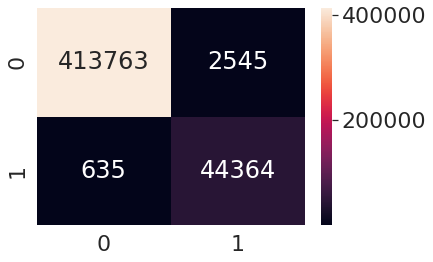

In [21]:
print("Accuracy = ", metrics.accuracy_score(y_val, prediction_xgb))
print("Precision = ", metrics.precision_score(y_val, prediction_xgb, average='macro'))
print("Recall = ", metrics.recall_score(y_val, prediction_xgb, average='macro'))
print("F1 = ", metrics.f1_score(y_val, prediction_xgb, average='macro'))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_val, prediction_xgb)
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

In [22]:
# see avg row per flow in test set
# prepare new test set, see the result (keeping first 5/10 second data)
# downsample existing test set to compare with step 2
# apply DL or other techniques to improve precision

In [23]:
len(val_df)

461307

In [24]:
len(val_df["flow_id"].unique())

123458

In [25]:
res = {} # flow_id: count

for i in range(0, len(val_df['flow_id'])):
    if val_df['flow_id'][i] in res.keys():
        res[val_df['flow_id'][i]] += 1
    else:
        res[val_df['flow_id'][i]] = 1

In [26]:
count = 0
for k,v in res.items():
    count+=v
print("Avg rows per flow: ", count/len(res.keys()))

Avg rows per flow:  3.7365500818091983


In [18]:
# prepare new test set
N = 1
res = {} # flow_id: count
print("Length of old val set: ", len(val_df))
for i in tqdm(range(0, len(val_df['flow_id']))):
    if val_df['flow_id'][i] in res.keys():
        res[val_df['flow_id'][i]] += 1
        if res[val_df['flow_id'][i]] > N:
            val_df.drop(i, inplace=True)
    else:
        res[val_df['flow_id'][i]] = 1
print("Length of new val set: ", len(val_df))
val_df.to_csv("./val_df_"+str(N)+".csv")

Length of old val set:  461307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461307/461307 [2:13:07<00:00, 57.75it/s]


Length of new val set:  123458


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123458/123458 [15:50<00:00, 129.93it/s]


Accuracy =  0.9917461808874273
Precision =  0.9655018336089678
Recall =  0.9857357774331803
F1 =  0.9753480766923683
[[111565    779]
 [   240  10874]]


<AxesSubplot:>

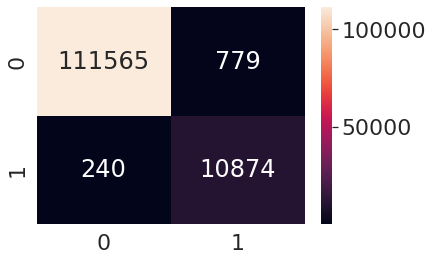

In [19]:
# majority voting evaluation
import pickle
RF_model = pickle.load(open("./Random_Forest.sav", 'rb'))

pred = {} # flow_id : [prediction]
true = {}

val_df = val_df.reset_index(drop=True)

X_val = val_df[features]
y_val = val_df["label"]
val_scaled_X = train_scaler.transform(X_val)
# import pdb;pdb.set_trace()
for i in tqdm(range(0, len(val_df['flow_id']))):
    if val_df['flow_id'][i] in pred.keys():
        pred[val_df['flow_id'][i]].append(le.inverse_transform(RF_model.predict(val_scaled_X[i].reshape(1,-1))))
        true[val_df['flow_id'][i]].append(y_val[i])
    else:
        pred[val_df['flow_id'][i]] = [le.inverse_transform(RF_model.predict(val_scaled_X[i].reshape(1,-1)))]
        true[val_df['flow_id'][i]] = [y_val[i]]

final_pred = []
final_act = []

for k,v in pred.items():
    final_pred.append(max(pred[k], key=pred[k].count))
    final_act.append(max(true[k], key=true[k].count))
    
print("Accuracy = ", metrics.accuracy_score(final_act, final_pred))
print("Precision = ", metrics.precision_score(final_act, final_pred, average='macro'))
print("Recall = ", metrics.recall_score(final_act, final_pred, average='macro'))
print("F1 = ", metrics.f1_score(final_act, final_pred, average='macro'))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(final_act, final_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

Accuracy =  0.9917461808874273
Precision =  0.9655018336089678
Recall =  0.9857357774331803
F1 =  0.9753480766923683
[[111565    779]
 [   240  10874]]


<AxesSubplot:>

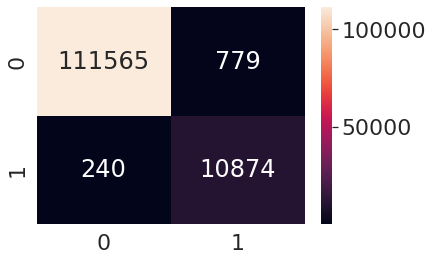

In [19]:
import pickle
RF_model = pickle.load(open("./Random_Forest.sav", 'rb'))

X_val = val_df[features]
y_val = val_df["label"]
val_scaled_X = train_scaler.transform(X_val)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(val_scaled_X)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

print("Accuracy = ", metrics.accuracy_score(y_val, prediction_RF))
print("Precision = ", metrics.precision_score(y_val, prediction_RF, average='macro'))
print("Recall = ", metrics.recall_score(y_val, prediction_RF, average='macro'))
print("F1 = ", metrics.f1_score(y_val, prediction_RF, average='macro'))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_val, prediction_RF)
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

<BarContainer object of 2 artists>

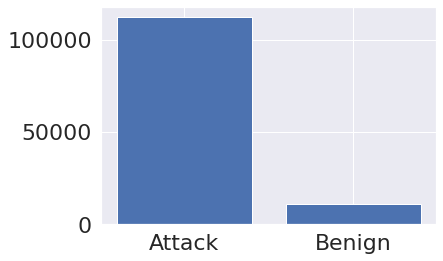

In [20]:
plt.bar(["Attack", "Benign"], [len(val_df[val_df["label"]=="attack"]),\
                               len(val_df[val_df["label"]=="benign"])])

Text(0, 0.5, 'Precision')

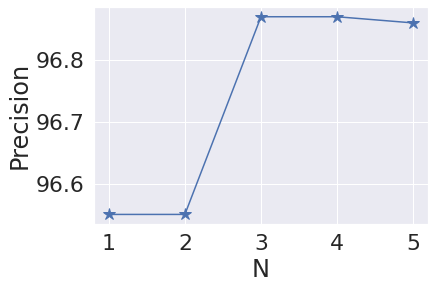

In [15]:
points = [96.55, 96.55, 96.87, 96.87, 96.86]

# default_y_ticks = [x for x in range(95,98,1)]
plt.plot([1,2,3,4,5],points, marker="*", markersize=12)
plt.xlabel("N")
plt.ylabel("Precision")
# plt.yticks(default_y_ticks, default_y_ticks)

Text(0, 0.5, 'Accuracy')

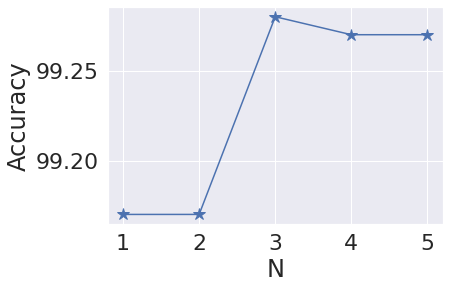

In [14]:
points = [99.17, 99.17, 99.28, 99.27, 99.27]

# default_y_ticks = [x for x in range(98,101,1)]
plt.plot([1,2,3,4,5],points, marker="*", markersize=12)
plt.xlabel("N")
plt.ylabel("Accuracy")
# plt.yticks(default_y_ticks, default_y_ticks)